In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import random

In [2]:
# Load a pre-trained MobileNetV3 CNN
neural_net = torchvision.models.mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1, progress=False)
transform = torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

In [3]:
# Overwrite the neural_net.classifier[3] layer with a linear layer having 10 outputs
neural_net.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

In [4]:
# Training parameters
learning_rate = 0.001
weight_decay = 0.000001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [5]:
# Load the STL10 dataset
stl10_dataset = torchvision.datasets.STL10(root='./', split='train', transform=transform,
                                               download=True)
train_dataset, validation_dataset = torch.utils.data.random_split(stl10_dataset, [0.8, 0.2])
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=None)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, sampler=None)
# List of human-readable classes
stl10_classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

Files already downloaded and verified


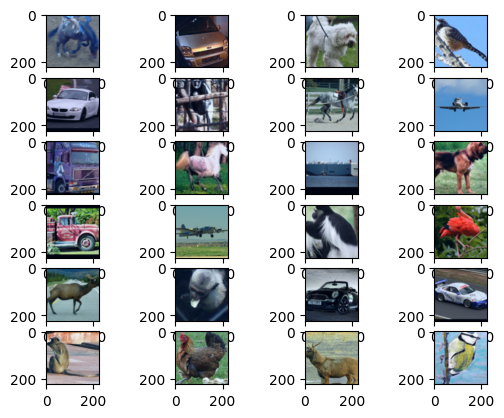

In [6]:
# Display some images from the dataset
# Create an array of images
number_of_rows = 6
number_of_columns = 4
fig, axs = plt.subplots(number_of_rows, number_of_columns)
for row in range(number_of_rows):
    for col in range(number_of_columns):
        index = random.randint(0, len(stl10_dataset) - 1)  # Choose a random index from the dataset
        img_tsr, class_ndx = stl10_dataset[index]  # Get the image tensor and the target class index
        img_tsr = torch.moveaxis(img_tsr, 0, 2)  # (C, H, W) -> (H, W, C)
        # Set the range to [0, 1]
        min_val = torch.min(img_tsr)
        max_val = torch.max(img_tsr)
        img_tsr = (img_tsr - min_val)/(max_val - min_val)
        axs[row, col].imshow(img_tsr.squeeze(0).numpy())
plt.show()

In [7]:
# Record statistics
epochs = []
train_losses = []
validation_losses = []
accuracies = []
number_of_epochs = 4
highest_validation_accuracy = 0.0
champion_neural_net = None

def numberOfCorrectPredictions(predictions_tsr, target_class_tsr):
    return sum(torch.argmax(predictions_tsr, dim=1) == target_class_tsr).item()

In [8]:
# The training loop
for epoch in range(1, number_of_epochs + 1):
    # Set the neural network to training mode
    neural_net.train()
    running_loss = 0.0
    number_of_batches = 0
    for input_tsr, target_class_tsr in train_dataloader:
        # Set the parameter gradients to zero before every batch
        neural_net.zero_grad()
        # Pass the input tensor through the neural network
        output_tsr = neural_net(input_tsr)
        # Compute the loss, i.e., the error function we want to minimize
        loss = criterion(output_tsr, target_class_tsr)
        # Back-propagate the loss function, to compute the gradient of the loss function with
        # respect to every trainable parameter in the neural network
        loss.backward()
        # Perturb every trainable parameter by a small quantity, in the direction of the steepest loss descent
        optimizer.step()

        running_loss += loss.item()
        number_of_batches += 1
        if number_of_batches % 10 == 1:
            print('.', flush=True, end='')
    average_training_loss = running_loss / number_of_batches

    # Evaluate with the validation dataset
    # Set the neural network to evaluation (inference) mode
    neural_net.eval()
    validation_running_loss = 0.0
    number_of_batches = 0
    number_of_correct_predictions = 0
    number_of_predictions = 0
    for validation_input_tsr, validation_target_output_tsr in validation_dataloader:
        # Pass the input tensor through the neural network
        validation_output_tsr = neural_net(validation_input_tsr)
        # Compute the validation loss
        validation_loss = criterion(validation_output_tsr, validation_target_output_tsr)
        validation_running_loss += validation_loss.item()
        number_of_correct_predictions += numberOfCorrectPredictions(validation_output_tsr,
                                                                    validation_target_output_tsr)
        number_of_predictions += validation_input_tsr.shape[0]
        number_of_batches += 1
    average_validation_loss = validation_running_loss / number_of_batches
    accuracy = number_of_correct_predictions / number_of_predictions
    print(
        f"Epoch {epoch}: average_training_loss = {average_training_loss}; average_validation_loss = {average_validation_loss}; accuracy = {accuracy}")
    epochs.append(epoch)
    train_losses.append(average_training_loss)
    validation_losses.append(average_validation_loss)
    accuracies.append(accuracy)

    if (accuracy > highest_validation_accuracy):
        print(f" * * * * Champion! * * * * ")
        torch.save(neural_net.state_dict(), "./neural_net.pth")
        highest_validation_accuracy = accuracy
        champion_neural_net = neural_net

.........................Epoch 1: average_training_loss = 0.6855223233401775; average_validation_loss = 0.8734926042102632; accuracy = 0.721
 * * * * Champion! * * * * 
.........................Epoch 2: average_training_loss = 0.27431305980682374; average_validation_loss = 0.9774571872419782; accuracy = 0.762
 * * * * Champion! * * * * 
.........................Epoch 3: average_training_loss = 0.2254403404928744; average_validation_loss = 1.0755221581175214; accuracy = 0.765
 * * * * Champion! * * * * 
.........................Epoch 4: average_training_loss = 0.18711093151569366; average_validation_loss = 0.7379162811807224; accuracy = 0.812
 * * * * Champion! * * * * 


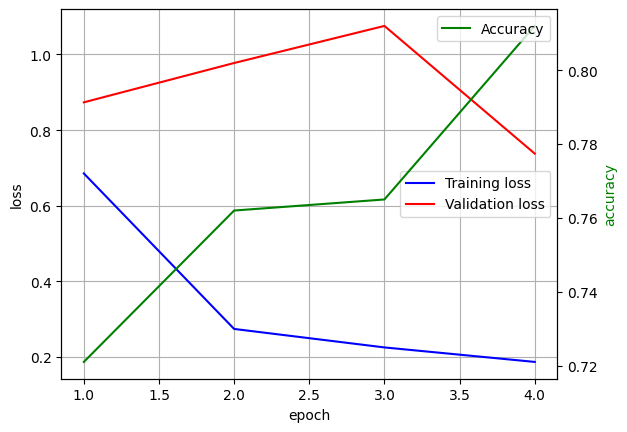

In [9]:
# Display the evolution of the metrics
fig1, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(epochs, train_losses, color='b', label='Training loss')
ax1.plot(epochs, validation_losses, color='r', label='Validation loss')
ax1.grid(True)
ax1.legend(loc='right')
ax2 = ax1.twinx()  # Instantiate a second axis that shares the same x-axis
ax2.set_ylabel('accuracy', color='g')
ax2.plot(epochs, accuracies, color='g', label='Accuracy')
ax2.legend(loc='upper right')
plt.show()

In [10]:
# Test the champion neural network
stl10_test_dataset = torchvision.datasets.STL10(root="./", split='test', transform=transform, download=False)

In [14]:
# Choose a random index in [0, 7999]
sample_ndx = 105
sample_test_tsr, class_ndx = stl10_test_dataset[sample_ndx]
champion_neural_net.eval()
sample_output_tsr = champion_neural_net(sample_test_tsr.unsqueeze(0).to('cpu') )
print(f"sample_output_tsr = \n{sample_output_tsr}")
predicted_class = torch.argmax(sample_output_tsr, dim=1).item()
print(f"predicted_class = {predicted_class} ({stl10_classes[predicted_class]}); True class = {class_ndx} ({stl10_classes[class_ndx]})")

sample_output_tsr = 
tensor([[-8.4146, -2.2548, -3.7811,  4.0926, -3.4772,  0.8759, -2.5404,  9.1017,
         -8.4914, -4.4986]], grad_fn=<AddmmBackward0>)
predicted_class = 7 (monkey); True class = 7 (monkey)


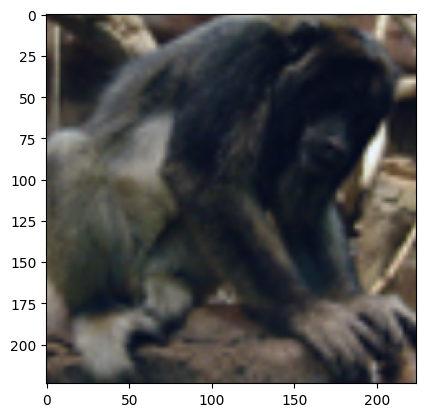

In [15]:
sample_test_tsr = torch.moveaxis(sample_test_tsr, 0, 2)
# Set the range to [0, 1]
min_val = torch.min(sample_test_tsr)
max_val = torch.max(sample_test_tsr)
sample_test_tsr = (sample_test_tsr - min_val)/(max_val - min_val)
plt.imshow(sample_test_tsr.squeeze(0))